In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 10.8 MB/s eta 0:00:00


In [ ]:
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Rotaciones

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """Finds angle between two vectors"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def x_rotation(vector,theta):
    """Rotates 3-D vector around x-axis"""
    R = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0, np.sin(theta), np.cos(theta)]])
    return np.dot(R,vector)

def y_rotation(vector,theta):
    """Rotates 3-D vector around y-axis"""
    R = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(R,vector)

def z_rotation(vector,theta):
    """Rotates 3-D vector around z-axis"""
    R = np.array([[np.cos(theta), -np.sin(theta),0],[np.sin(theta), np.cos(theta),0],[0,0,1]])
    return np.dot(R,vector)

def u_rotation(u,v,theta):
  """Rotates over an arbitrary u vector as rotating axes, a  vector v an angle theta"""
  ux=u[0]
  uy=u[1]
  uz=u[2]
  ux2=np.square(ux)
  uy2=np.square(uy)
  uz2=np.square(uz)
  ct=np.cos(theta)
  st=np.sin(theta)
  omct= 1 - ct
  R=np.matrix([
      [ct + ux2 * omct, ux*uy*omct - uz*st, ux*uz*omct+uy*st],
      [uy*ux*omct+uz*st, ct+uy2 * omct, uy*uz*omct-ux*st],
      [uz*ux*omct-uy*st, uz*uy*omct+ux*st, ct + uz2*omct]
  ])
  
  R = np.matmul(R,v)
  return np.asarray(R).reshape(-1)
  

#Age Photos

In [ ]:
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [ ]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Setup the face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)

# Setup the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, 
                                         min_detection_confidence=0.5,min_tracking_confidence=0.3)

# Initialize the mediapipe drawing styles class.


mp_drawing_styles = mp.solutions.drawing_styles

#Initialize the mediapipe face detection class.
mp_face_detection = mp.solutions.face_detection

# Setup the face detection function.
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

In [ ]:
i=np.array([1,0,0])
j=np.array([0,1,0])
k=np.array([0,0,1])

def NormalizedPoints3D(img):
  #print(img)
  sample_img=cv2.imread(img)
# Perform face landmarks detection after converting the image into RGB format.
  face_mesh_results = face_mesh_images.process(sample_img[:,:,::-1])

# Get the list of indexes of the left and right eye.
  LEFT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYE)))
  RIGHT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYE)))

  averageLeft=np.array([])
  averageRight=np.array([])

  vector=np.array([])
  image_input = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

  face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)
  image_rows, image_cols, _ = sample_img.shape
  results = face_mesh.process(cv2.cvtColor(image_input , cv2.COLOR_BGR2RGB))

  ls_single_face=results.multi_face_landmarks[0].landmark
  for idx in ls_single_face:
     
     vector=np.append(vector, np.array([
                       idx.x,
                       idx.y,
                       idx.z
                      ])
     )
 
  vector=np.reshape(vector,(468,3)) 

  avLeft=0.5*np.array([vector[386,0]+vector[374,0],vector[386,1]+vector[374,1],vector[386,2]+vector[374,2]])
  avRight=0.5*np.array([vector[159,0]+vector[145,0],vector[159,1]+vector[145,1],vector[159,2]+vector[145,2]])
  d=avLeft-avRight
  distance=np.sqrt(d[0]*d[0]+d[1]*d[1]+d[2]*d[2])

 
  vector = (vector - avRight)/distance
  

  Xangle=angle_between(i,d)
 
  
  u=unit_vector(np.cross(d,i))
 
  rot_vec=np.array([])
  
  for v in vector:
    
    rot_vec =np.append(rot_vec,u_rotation(u,v,Xangle))
  rot_vec=np.reshape(rot_vec,(468,3))
  d=u_rotation(u,v,Xangle)
 


  return rot_vec


Text(0.5, 0, 'Z')

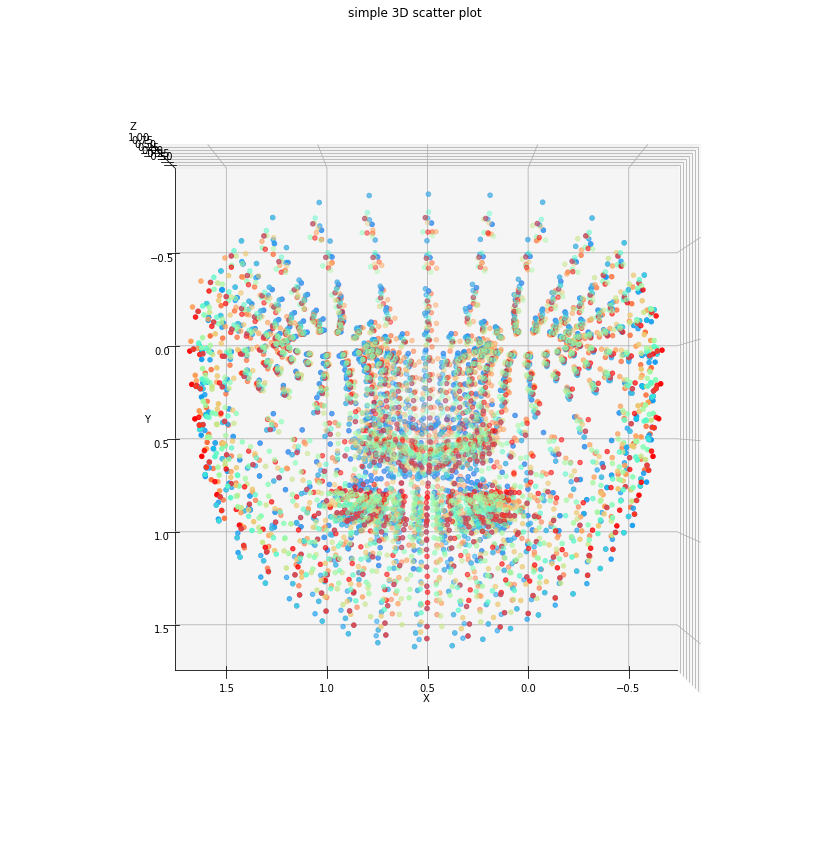

In [ ]:
path="/content/drive/MyDrive/ANN Dataset/fg_net/fg_net_images/FGNET/images/"
ages= ("A02","A05","A28","A43a","A02","A05","A08","A10","A14","A16","A18","A19","A22","A28","A29")
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
angle = 90 #90
ax.view_init(90, angle)
color = iter(cm.rainbow(np.linspace(0, 1, len(ages))))
for a in ages:
  v= NormalizedPoints3D(path + "001"+a+".JPG")
  x = v[:,0]
  y = v[:,1]
  z = v[:,2]
  # Creating plot
  ax.scatter3D(x, y, z, color = next(color))
  plt.title("simple 3D scatter plot")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.scatter3D(avLeft[0],avLeft[1],avLeft[2],color="red")
#ax.scatter3D(avRight[0],avRight[1],avRight[2],color="blue")
#x,y,z = NormalizedPoints3D(path + "001A05.JPG")
#angle = 180
# Creating plot
#ax.view_init(90, angle)
#ax.scatter3D(x, y, z, color = "blue")
#plt.title("simple 3D scatter plot")



In [ ]:
import pandas as pd

In [ ]:
v=v.reshape(1404,1)
df=pd.DataFrame(data=v).T

In [ ]:
df

0        1         2         3         4         5         6     \
0  0.481553  0.73316 -0.236881  0.479534  0.521382 -0.513813  0.477681   

       7         8         9     ...      1394      1395      1396      1397  \
0  0.581233 -0.257388  0.406445  ... -0.036549  0.642441  0.074817 -0.107796   

       1398      1399      1400      1401      1402      1403  
0  1.176361 -0.002544  0.079292  1.221959 -0.012205  0.078241  

[1 rows x 1404 columns]

In [ ]:
df